<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/machine_learning_for_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## memory 예측 (점진적 패턴, 느린 주기)
### 요청과 작업에 바로 반응하는 cpu와 달리 재사용을 위해 일정 기간 유지하기 때문

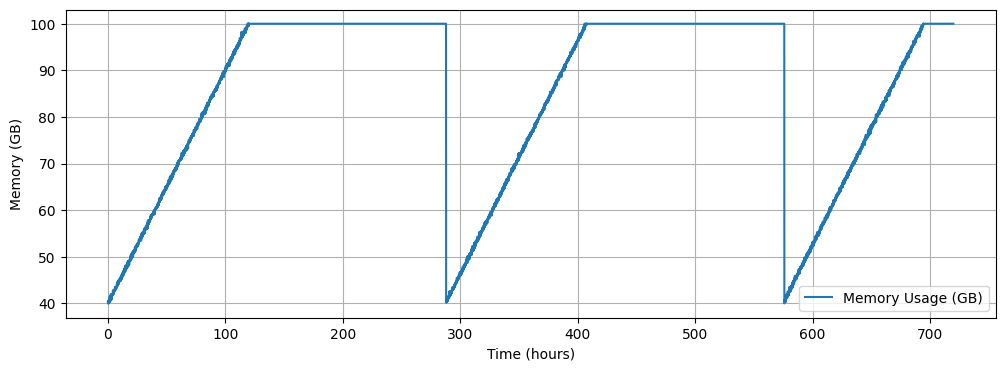

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

days = 30
interval_minutes = 5 # 5분 간격
steps_per_day = int(24*60/interval_minutes)
total_steps = days * steps_per_day

t = np.arange(total_steps) * interval_minutes / 60.0  # 시간 단위

# 톱니파 패턴 → 메모리 점점 쌓이다가 GC/재시작으로 초기화
gc_cycle = 12 * steps_per_day  # 12시간마다 cycle
mem_saw = (t % (gc_cycle/steps_per_day*24)) * 0.5

mem_trend = 0.001 * t  # 30일 동안 약간씩 상승

mem_noise = np.random.normal(0, 0.3, total_steps) # 노이즈 추가

# 메모리 사용량 (%)
base_memory = 40  # 최소 40%
memory_usage = base_memory + mem_saw + mem_trend + mem_noise

# 100% 넘지 않도록
memory_usage = np.clip(memory_usage, 0, 100)

plt.figure(figsize=(12,4))
plt.plot(t, memory_usage, label="Memory Usage (%)")
plt.xlabel("Time (hours)")
plt.ylabel("Memory (%)")
plt.legend()
plt.grid(True)
plt.show()


### 주기적 실행 +  임계값 넘으면 감소시키도록 (40~100사이)

## 복잡한 memory 사용량 형태

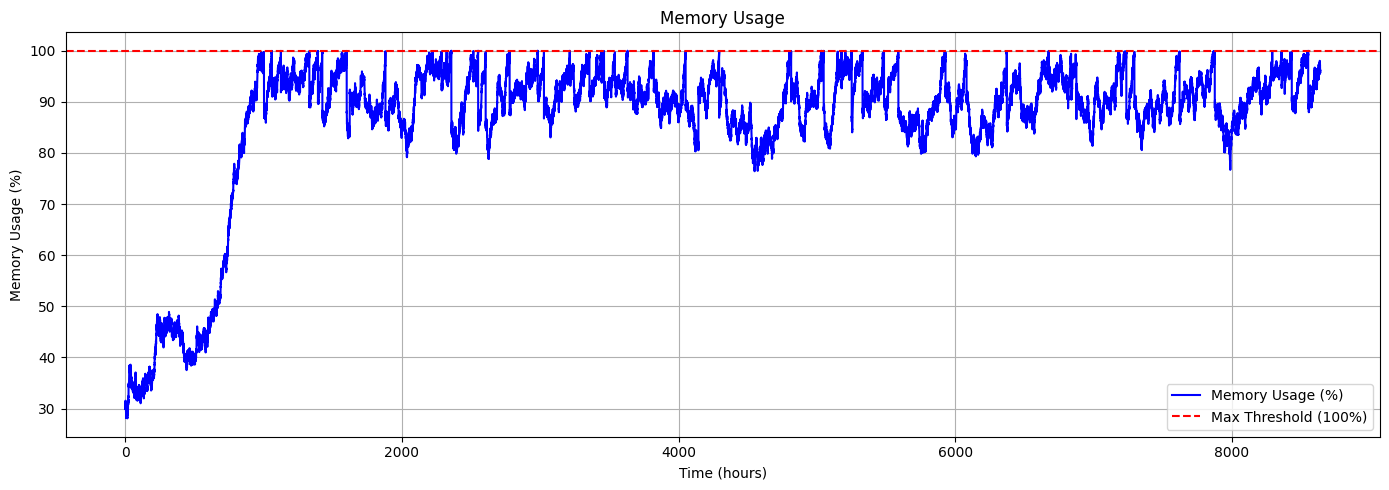

In [13]:
# 증설 필요한 상황
import numpy as np
import matplotlib.pyplot as plt

days = 360
interval_minutes = 5
steps_per_day = int(24 * 60 / interval_minutes)
total_steps = days * steps_per_day
time_hours = np.arange(total_steps) * (interval_minutes / 60)

baseline = 30
threshold = 100
growth_per_step = 0.005
small_noise_std = 0.2
gc_release_range = (5, 15)

# spike 설정
event_spikes = np.zeros(total_steps)
for _ in range(5):
    idx = np.random.randint(0, total_steps - 5)
    spike_val = np.random.uniform(3, 6)
    event_spikes[idx:idx+2] += spike_val

for _ in range(5):
    idx = np.random.randint(0, total_steps - 2)
    spike_val = np.random.uniform(40, 55)
    event_spikes[idx] += spike_val

memory_usage = []
current_mem = baseline

for i in range(total_steps):
    current_mem += growth_per_step + np.random.normal(0, small_noise_std) + event_spikes[i]

    # max threshold 초과하지 않도록 제한
    if current_mem > threshold:
        current_mem = threshold

    # GC 작동
    if current_mem >= threshold:
        release_amount = np.random.uniform(*gc_release_range)
        current_mem -= release_amount
        current_mem = max(current_mem, baseline)

    memory_usage.append(current_mem)

memory_usage = np.array(memory_usage)

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(time_hours, memory_usage, label="Memory Usage (%)", color='blue')
plt.axhline(threshold, color='red', linestyle='--', label="Max Threshold (100%)")
plt.title("Memory Usage")
plt.xlabel("Time (hours)")
plt.ylabel("Memory Usage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


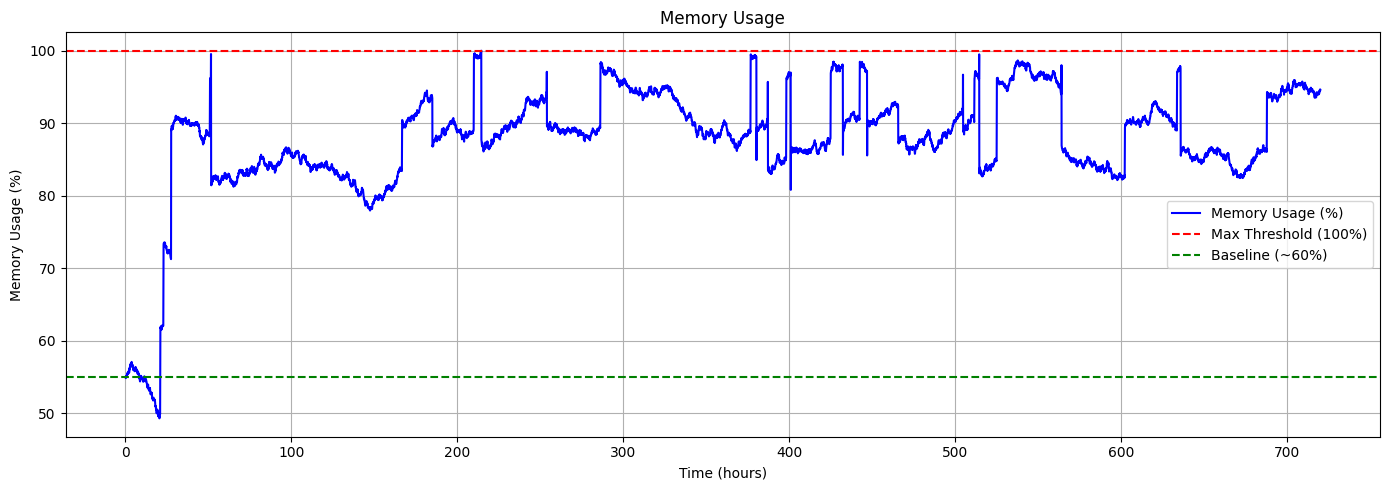

In [31]:
# import numpy as np
# import matplotlib.pyplot as plt

# days = 30
# interval_minutes = 5
# steps_per_day = int(24 * 60 / interval_minutes)
# total_steps = days * steps_per_day
# time_hours = np.arange(total_steps) * (interval_minutes / 60)


# baseline = 55
# threshold = 100
# growth_per_step = 0.005
# small_noise_std = 0.15
# gc_release_range = (10, 20)

# # spike
# event_spikes = np.zeros(total_steps)
# for _ in range(25):
#     idx = np.random.randint(0, total_steps - 5)
#     spike_val = np.random.uniform(3, 6)
#     event_spikes[idx:idx+2] += spike_val

# # 강한 spike
# for _ in range(5):
#     idx = np.random.randint(0, total_steps - 2)
#     spike_val = np.random.uniform(40, 55)
#     event_spikes[idx] += spike_val


# memory_usage = []
# current_mem = baseline

# for i in range(total_steps):
#     current_mem += growth_per_step + np.random.normal(0, small_noise_std) + event_spikes[i]

#     current_mem = min(current_mem, threshold)

#     if current_mem >= threshold:
#         release_amount = np.random.uniform(*gc_release_range)
#         current_mem -= release_amount
#         current_mem = max(current_mem, baseline)

#     memory_usage.append(current_mem)

# memory_usage = np.array(memory_usage)


# plt.figure(figsize=(14, 5))
# plt.plot(time_hours, memory_usage, label="Memory Usage (%)", color='blue')
# plt.axhline(threshold, color='red', linestyle='--', label="Max Threshold (100%)")
# plt.axhline(baseline, color='green', linestyle='--', label="Baseline (~60%)")
# plt.title("Memory Usage")
# plt.xlabel("Time (hours)")
# plt.ylabel("Memory Usage (%)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [14]:
# 하루 시간 반복을 위해 모듈로 24
hour_of_day = time_hours % 24

# 업무시간: 08:00 ~ 17:30
working_hour_mask = (hour_of_day >= 8.0) & (hour_of_day < 17.5)
working_hour_memory = memory_usage[working_hour_mask]
working_hour_avg = np.mean(working_hour_memory)

print(f"업무시간 메모리 평균 사용량: {working_hour_avg:.2f}%")


업무시간 메모리 평균 사용량: 86.52%


## 1. CNN-LSTM 적용 + sliding window(5)
### EX) 12*24*30 = 8640, 8640-20(past step)-5(future step) = 8615
### 8615*0.2 = 1723 stamp (전체 test 스탬프 수)

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

# 위에서 생성한 memory_usage, time_hours 활용
time_index = pd.date_range('2025-06-01', periods=len(memory_usage), freq='5T')

df = pd.DataFrame({'timestamp': time_index, 'memory': memory_usage})
df.set_index('timestamp', inplace=True)

scaler = MinMaxScaler()
scaled_mem = scaler.fit_transform(df[['memory']].values)

def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset)-past_steps-future_steps):
        X.append(dataset[i:i+past_steps])                  # 과거 20 step
        y.append(dataset[i+past_steps:i+past_steps+future_steps])  # 미래 5 step
    return np.array(X), np.array(y)

past_steps = 20    # 과거 20 step 입력
future_steps = 5   # 미래 5 step 예측

X, y = create_sequences(scaled_mem, past_steps, future_steps)
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"입력 X_train shape: {X_train.shape}, 출력 y_train shape: {y_train.shape}")

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                 input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, activation='relu'))
model.add(Dense(future_steps))  # 미래 5 step 예측
model.compile(optimizer='adam', loss='mse')

model.fit(
    X_train,
    y_train.reshape((y_train.shape[0], -1)),  # (샘플, future_steps)
    epochs=50,
    batch_size=16,
    verbose=1
)

pred = model.predict(X_test)
pred = pred.reshape(-1, future_steps)
y_true = y_test.reshape(-1, future_steps)

# 정확도 분석
y_true_first = scaler.inverse_transform(y_true[:, 0].reshape(-1, 1))
pred_first = scaler.inverse_transform(pred[:, 0].reshape(-1, 1))



/tmp/ipython-input-15-4240739557.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range('2025-06-01', periods=len(memory_usage), freq='5T')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


입력 X_train shape: (82924, 20, 1), 출력 y_train shape: (82924, 5, 1)
Epoch 1/50
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0078
Epoch 2/50
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 1.1185e-04
Epoch 3/50
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 9.6355e-05
Epoch 4/50
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 8.6818e-05
Epoch 5/50
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 8.1631e-05
Epoch 6/50
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 7.6712e-05
Epoch 7/50
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 7.3390e-05
Epoch 8/50
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 6.9539e-05
Epoch 9/50
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 7.4379e-05
Epoch 10/50
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 7.3144e-05
Epoch 11/50
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 6.4544e-05
Epoch 12/50
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 6.8051e-05
Epoch 13/50
5183/5183 ━━━━━━━━━━━━━━━━━━━━ 21s 

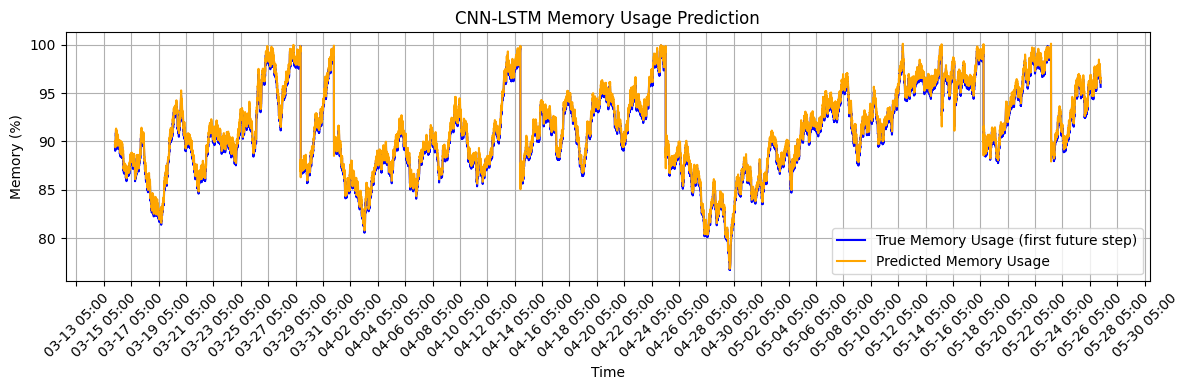

In [16]:
import matplotlib.dates as mdates
test_start_idx = train_size + past_steps  # past_steps만큼 offset

# 테스트 구간 timestamp (pred 길이에 맞춰 잘라줌)
test_time_index = df.index[test_start_idx + future_steps : test_start_idx + future_steps + len(pred_first)]
plt.figure(figsize=(12,4))
plt.plot(test_time_index, y_true_first, label="True Memory Usage (first future step)", color='blue')
plt.plot(test_time_index, pred_first, label="Predicted Memory Usage", color='orange')

plt.title("CNN-LSTM Memory Usage Prediction")
plt.ylabel("Memory (%)")
plt.xlabel("Time")

plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=48))  # 원하는 시간 간격으로 x 절편
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))

plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Result for Moving Average
MAE : 0.4592
RMSE: 0.7304

Result for CNN-LSTM
MAE : 0.3538
RMSE: 0.5450


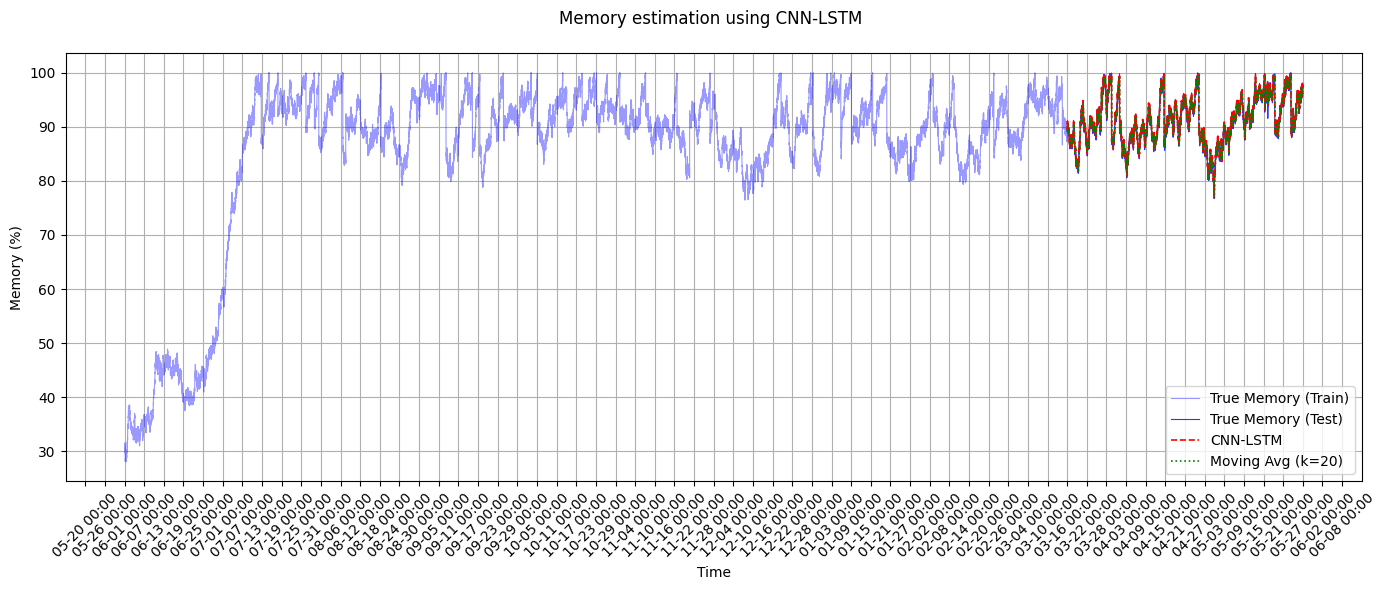

In [19]:
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error

train_end_idx = train_size + past_steps  # past_steps만큼 offset된 위치
train_time_index = df.index[:train_end_idx]    # train 기간 timestamp
test_time_index  = df.index[train_end_idx:]    # test 기간 timestamp

full_memory = df['memory']

y_true_inv = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(y_test.shape)
# 미래 5 step 중 첫 step만 "실제 test target"으로
true_test_first = y_true_inv[:,0].reshape(-1)

true_test_first_time = test_time_index[:len(true_test_first)]
test_series_true = pd.Series(true_test_first, index=true_test_first_time)

future_steps = 5
future_interval = 5  # 5분 단위

all_future_times, all_future_preds = [], []
for i in range(len(test_time_index[:len(pred)])):
    for j in range(future_steps):
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({
    "time": all_future_times,
    "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()
})
pred_df_mean = pred_df.groupby("time").mean().sort_index()

# CNN-LSTM 예측 시리즈 (테스트 구간과 align)
test_series_pred = pred_df_mean['pred'].reindex(test_series_true.index, method="nearest")


# 5. Moving Average
k = 20  # 최근 20 step(100분) 평균
moving_avg_pred = []
for i in range(k, len(test_series_true)):
    moving_avg_pred.append(np.mean(test_series_true.iloc[i-k:i]))

moving_avg_pred_series = pd.Series(
    moving_avg_pred,
    index=test_series_true.index[k:]
)

# 정확도 분석
true_vals = test_series_true.values
cnn_pred_vals = test_series_pred.values

mae_cnn = mean_absolute_error(true_vals, cnn_pred_vals)
rmse_cnn = np.sqrt(mean_squared_error(true_vals, cnn_pred_vals))

true_vals_ma = true_vals[k:]  # Moving Average는 k step 이후만 비교 가능
mae_ma = mean_absolute_error(true_vals_ma, moving_avg_pred)
rmse_ma = np.sqrt(mean_squared_error(true_vals_ma, moving_avg_pred))

print("Result for Moving Average")
print(f"MAE : {mae_ma:.4f}")
print(f"RMSE: {rmse_ma:.4f}")
# print(f"R²  : {r2_ma:.4f}")

print("\nResult for CNN-LSTM")
print(f"MAE : {mae_cnn:.4f}")
print(f"RMSE: {rmse_cnn:.4f}")
# print(f"R²  : {r2_cnn:.4f}")


plt.figure(figsize=(14,6))

plt.plot(train_time_index, full_memory.loc[train_time_index], label="True Memory (Train)", color='blue', alpha=0.4, linewidth=0.8)
plt.plot(test_series_true.index, test_series_true.values, label="True Memory (Test)", color="blue", alpha=0.8, linewidth=0.8)
plt.plot(test_series_pred.index, test_series_pred.values, label="CNN-LSTM", color='red',linestyle="--", linewidth=1.2)
plt.plot(moving_avg_pred_series.index, moving_avg_pred_series.values, label=f"Moving Avg (k={k})", color='green', linestyle=':',linewidth = 1.2)

plt.title(f"Memory estimation using CNN-LSTM \n")

plt.xlabel("Time")
plt.ylabel("Memory (%)")
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=144)) # x축 시간 단위
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.xticks(rotation=45) # 시간 legend 회전으로 표시

plt.tight_layout()
plt.show()


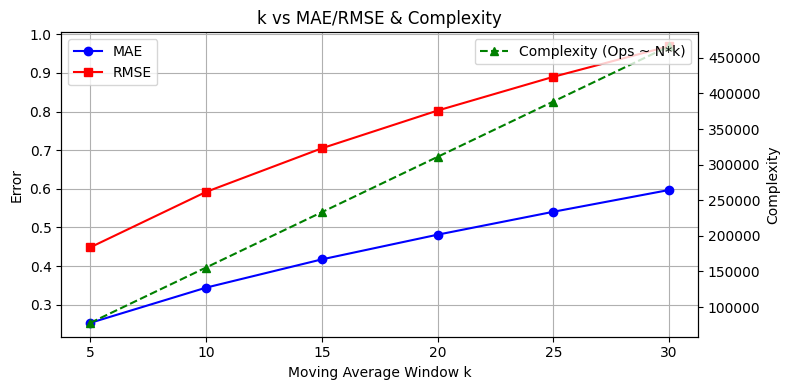

k= 5  MAE=0.2532  RMSE=0.4486  Complexity≈77735 ops
k=10  MAE=0.3443  RMSE=0.5920  Complexity≈155470 ops
k=15  MAE=0.4175  RMSE=0.7049  Complexity≈233205 ops
k=20  MAE=0.4814  RMSE=0.8026  Complexity≈310940 ops
k=25  MAE=0.5407  RMSE=0.8899  Complexity≈388675 ops
k=30  MAE=0.5971  RMSE=0.9692  Complexity≈466410 ops


In [7]:
k_list = [5, 10, 15, 20, 25, 30]  # 테스트할 이동평균 윈도우
results = []  # (k, mae, rmse, complexity)

for k in k_list:
    ma_pred = []
    for i in range(k, len(test_series_true)):
        ma_pred.append(np.mean(test_series_true[i-k:i]))

    # k step 이후
    true_vals_ma = test_series_true.values[k:]

    mae = mean_absolute_error(true_vals_ma, ma_pred)
    rmse = np.sqrt(mean_squared_error(true_vals_ma, ma_pred))

    complexity = len(test_series_true) * k

    results.append((k, mae, rmse, complexity))

results_arr = np.array(results)
k_values = results_arr[:,0]
mae_values = results_arr[:,1]
rmse_values = results_arr[:,2]
complexity_values = results_arr[:,3]

fig, ax1 = plt.subplots(figsize=(8,4))

ax1.plot(k_values, mae_values, marker='o', label="MAE", color='blue')
ax1.plot(k_values, rmse_values, marker='s', label="RMSE", color='red')
ax1.set_xlabel("Moving Average Window k")
ax1.set_ylabel("Error")
ax1.grid(True)
ax1.legend(loc="upper left")

# complexity
ax2 = ax1.twinx()
ax2.plot(k_values, complexity_values, marker='^', label="Complexity (Ops ~ N*k)", color='green', linestyle='--')
ax2.set_ylabel("Complexity")
ax2.legend(loc="upper right")

plt.title("k vs MAE/RMSE & Complexity")
plt.tight_layout()
plt.show()

for k, mae, rmse, comp in results:
    print(f"k={int(k):2d}  MAE={mae:.4f}  RMSE={rmse:.4f}  Complexity≈{int(comp)} ops")


## FLNN + GA-PSO

In [9]:
!pip install numpy deap pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.7 MB/s eta 0:00:00


/tmp/ipython-input-20-1768256710.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range('2025-06-01', periods=len(memory_usage), freq='5T')
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
2025-07-29 05:25:29,136 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}


입력 X shape: (103674, 5) 출력 y shape: (103674,)
MAE for GA: 0.34089807701121244


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.261
2025-07-29 05:25:31,278 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.26137165838623916, best pos: [ 0.64473019 -0.43319268 -0.01657753  0.61123263  0.18750402  0.59401213]


MAE for PSO: 0.26137165838623916


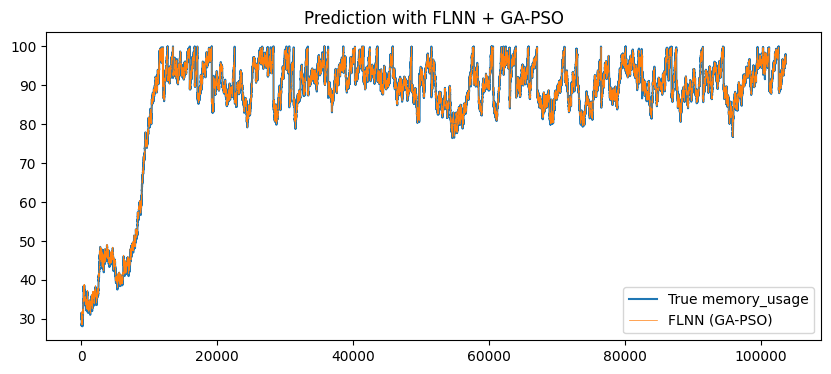

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

# 위에서 생성한 memory_usage, time_hours 활용
time_index = pd.date_range('2025-06-01', periods=len(memory_usage), freq='5T')

df = pd.DataFrame({'timestamp': time_index, 'memory': memory_usage})
df.set_index('timestamp', inplace=True)

# sliding window(1)
past_steps = 5
future_steps = 1

# sequence for data
X, y = [], []
for i in range(len(memory_usage)-past_steps-future_steps):
    X.append(memory_usage[i:i+past_steps])
    y.append(memory_usage[i+past_steps: i+past_steps+future_steps])
X = np.array(X)
y = np.array(y).flatten()

print("입력 X shape:", X.shape, "출력 y shape:", y.shape)

# FLNN 예측 : 입력 x에 대해 가중치 적용
def flnn_predict(weights, X):
    bias = weights[-1]
    return np.dot(X, weights[:-1]) + bias

from deap import base, creator, tools, algorithms

input_dim = past_steps
pop_size = 20
num_generations = 10

# 적합도: MAE 최소화
def eval_mae(individual):
    y_pred = flnn_predict(np.array(individual), X)
    return (np.abs(y - y_pred).mean(),)  # 튜플 반환

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=input_dim+1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", eval_mae)

pop = toolbox.population(n=pop_size)
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations, verbose=False)

# GA
best_ga = tools.selBest(pop, 1)[0]
print("MAE for GA:", eval_mae(best_ga)[0])

import pyswarms as ps

def pso_objective(w):
    # w: (num_particles, num_weights)
    losses = []
    for particle in w:
        y_pred = flnn_predict(particle, X)
        losses.append(np.abs(y - y_pred).mean())

    return np.array(losses)

# initial PSO
num_particles = 20
num_weights = input_dim + 1  # past_steps + bias

x_init = np.tile(best_ga, (num_particles, 1)) + np.random.normal(0, 0.1, (num_particles, num_weights))

options = {'c1': 1.5, 'c2': 1.5, 'w': 0.7}

optimizer = ps.single.GlobalBestPSO(
    n_particles=num_particles,
    dimensions=num_weights,
    options=options,
    init_pos=x_init
)

best_cost, best_pso = optimizer.optimize(pso_objective, iters=100)

print("MAE for PSO:", best_cost)

import matplotlib.pyplot as plt

# GA + PSO 함께 적용
final_weights = best_pso
y_pred = flnn_predict(final_weights, X)

plt.figure(figsize=(10,4))
plt.plot(y, label="True memory_usage")
plt.plot(y_pred, label="FLNN (GA-PSO)",linewidth = 0.5)
plt.legend()
plt.title("Prediction with FLNN + GA-PSO")
plt.show()


Result for Moving Average
MAE : 0.4593
RMSE: 0.7304

Aligned GA-PSO
MAE : 0.2473
RMSE: 0.4105


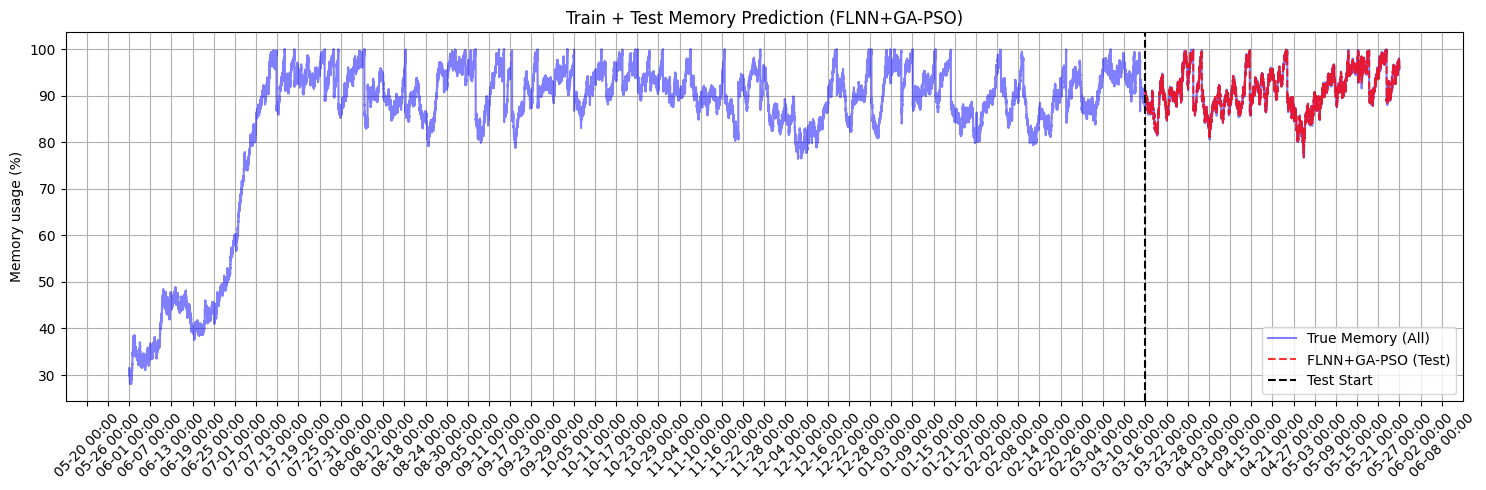

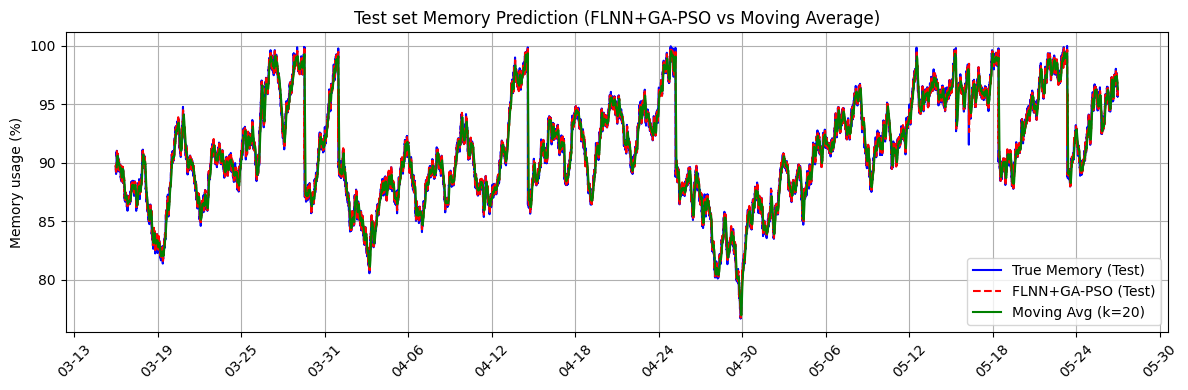

In [22]:
split_ratio = 0.8
split_idx = int(len(y) * split_ratio)

# Train, Test split
train_true = y[:split_idx]
test_true  = y[split_idx:]
train_pred = y_pred[:split_idx]
test_pred  = y_pred[split_idx:]

# time index
time_index_all = df.index[past_steps : past_steps + len(y)]
train_time_index = time_index_all[:split_idx]
test_time_index  = time_index_all[split_idx:]

# Evaluation
aligned_test_pred = test_pred[k:]
aligned_test_true = test_true[k:]

k = 20
ma_pred = [np.mean(test_true[i-k:i]) for i in range(k, len(test_true))]
ma_true_vals = test_true[k:]
mae_ma  = mean_absolute_error(ma_true_vals, ma_pred)
rmse_ma = np.sqrt(mean_squared_error(ma_true_vals, ma_pred))
print("Result for Moving Average")
print(f"MAE : {mae_ma:.4f}")
print(f"RMSE: {rmse_ma:.4f}")

mae_ga_pso_aligned  = mean_absolute_error(aligned_test_true, aligned_test_pred)
rmse_ga_pso_aligned = np.sqrt(mean_squared_error(aligned_test_true, aligned_test_pred))
print("\nAligned GA-PSO")
print(f"MAE : {mae_ga_pso_aligned:.4f}")
print(f"RMSE: {rmse_ga_pso_aligned:.4f}")

# mae_ga_pso  = mean_absolute_error(test_true, test_pred)
# rmse_ga_pso = np.sqrt(mean_squared_error(test_true, test_pred))
# print("\nResult for FLNN+GA-PSO")
# print(f"MAE : {mae_ga_pso:.4f}%")
# print(f"RMSE: {rmse_ga_pso:.4f}%")

plt.figure(figsize=(15,5))

plt.plot(time_index_all, y, label="True Memory (All)", color="blue", alpha=0.5)
plt.plot(test_time_index, test_pred, label="FLNN+GA-PSO (Test)", color="red", linestyle="--", alpha=0.8)

# start line for test datset
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")

# x축 legend 시간 간격 설정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
# plt.setp(ax.get_xticklabels(), rotation=90)
plt.xticks(rotation=45)
plt.ylabel("Memory usage (%)")
plt.title("Train + Test Memory Prediction (FLNN+GA-PSO)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# test data 부분만 따로 plot
plt.figure(figsize=(12,4))
plt.plot(test_time_index, test_true, label="True Memory (Test)", color="blue")
plt.plot(test_time_index, test_pred, label="FLNN+GA-PSO (Test)", color="red", linestyle="--")
plt.plot(test_time_index[k:], ma_pred, label=f"Moving Avg (k={k})", color="green", linestyle="-", linewidth = 1.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.setp(ax.get_xticklabels(), rotation=45)

plt.ylabel("Memory usage (%)")
plt.title("Test set Memory Prediction (FLNN+GA-PSO vs Moving Average)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

aligned_test_pred = test_pred[k:]
aligned_test_true = test_true[k:]



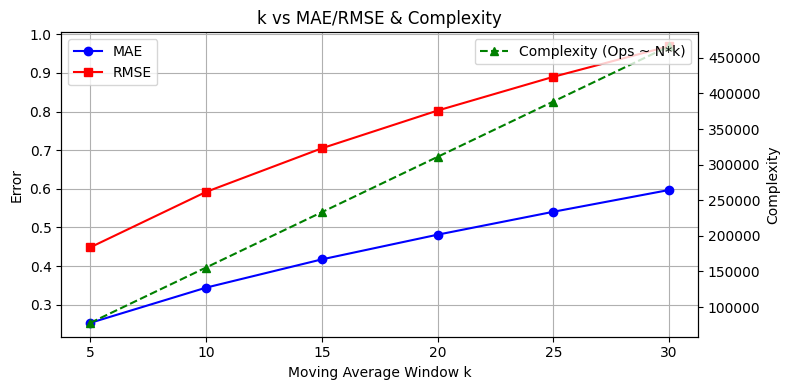

k= 5  MAE=0.2532  RMSE=0.4486  Complexity≈77735 ops
k=10  MAE=0.3443  RMSE=0.5920  Complexity≈155470 ops
k=15  MAE=0.4175  RMSE=0.7049  Complexity≈233205 ops
k=20  MAE=0.4814  RMSE=0.8026  Complexity≈310940 ops
k=25  MAE=0.5407  RMSE=0.8899  Complexity≈388675 ops
k=30  MAE=0.5971  RMSE=0.9692  Complexity≈466410 ops


In [12]:
k_list = [5, 10, 15, 20, 25, 30]  # 테스트할 이동평균 윈도우
results = []  # (k, mae, rmse, complexity)

for k in k_list:
    ma_pred = []
    for i in range(k, len(test_series_true)):
        ma_pred.append(np.mean(test_series_true[i-k:i]))

    # k step 이후
    true_vals_ma = test_series_true.values[k:]

    mae = mean_absolute_error(true_vals_ma, ma_pred)
    rmse = np.sqrt(mean_squared_error(true_vals_ma, ma_pred))

    complexity = len(test_series_true) * k

    results.append((k, mae, rmse, complexity))

results_arr = np.array(results)
k_values = results_arr[:,0]
mae_values = results_arr[:,1]
rmse_values = results_arr[:,2]
complexity_values = results_arr[:,3]

fig, ax1 = plt.subplots(figsize=(8,4))

ax1.plot(k_values, mae_values, marker='o', label="MAE", color='blue')
ax1.plot(k_values, rmse_values, marker='s', label="RMSE", color='red')
ax1.set_xlabel("Moving Average Window k")
ax1.set_ylabel("Error")
ax1.grid(True)
ax1.legend(loc="upper left")

# complexity
ax2 = ax1.twinx()
ax2.plot(k_values, complexity_values, marker='^', label="Complexity (Ops ~ N*k)", color='green', linestyle='--')
ax2.set_ylabel("Complexity")
ax2.legend(loc="upper right")

plt.title("k vs MAE/RMSE & Complexity")
plt.tight_layout()
plt.show()

for k, mae, rmse, comp in results:
    print(f"k={int(k):2d}  MAE={mae:.4f}  RMSE={rmse:.4f}  Complexity≈{int(comp)} ops")


## 기간 및 모델 별 결과 비교 그래프 (Mov_avg, CNN_LSTM, FLNN) (30,90,180,270,360일)

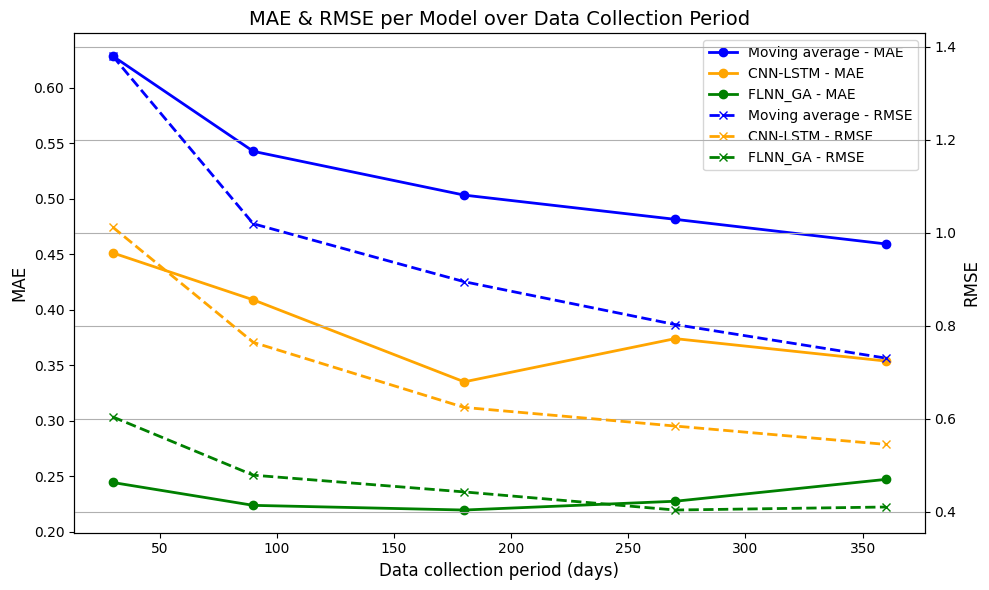

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 데이터 정의
periods = [30, 90, 180, 270, 360]

# mae_data = {
#     'Moving average': [0.6932, 0.7308, 0.6416, 0.6927, 0.6569],
#     'CNN-LSTM': [0.6053, 0.4928, 0.4415, 0.4464, 0.4063],
#     'FLNN_GA': [0.4103, 0.3652, 0.2663, 0.2296, 0.3616]
# }

# rmse_data = {
#     'Moving average': [1.6116, 1.6280, 1.5035, 1.6532, 1.5131],
#     'CNN-LSTM': [1.4071, 1.1906, 0.9829, 1.0515, 0.9680],
#     'FLNN_GA': [1.2347, 1.1979, 0.8300, 0.7540, 1.0528]
# }

mae_data = {
    'Moving average': [0.6284,0.5426,0.5032,0.4814,0.4592],
    'CNN-LSTM': [0.4512,0.4089,0.3351,0.374,0.3538],
    'FLNN_GA': [0.2445,0.2239,0.2197,0.2276,0.2473]
}

rmse_data = {
    'Moving average': [1.3797,1.0192,0.8947,0.8026,0.7304],
    'CNN-LSTM': [1.012,0.7643,0.6245,0.5845,0.545],
    'FLNN_GA': [0.6042,0.4789,0.4429,0.404,0.4105]
}

# 2. 색상 고정
colors = {
    'Moving average': 'blue',
    'CNN-LSTM': 'orange',
    'FLNN_GA': 'green'
}

# 3. 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()  # 오른쪽 y축

for model in mae_data:
    ax1.plot(periods, mae_data[model], marker='o', label=f'{model} - MAE', color=colors[model], linewidth=2)
    ax2.plot(periods, rmse_data[model], marker='x', linestyle='--', label=f'{model} - RMSE', color=colors[model], linewidth=2)

# 축 설정
ax1.set_xlabel("Data collection period (days)", fontsize=12)
ax1.set_ylabel("MAE", color='black', fontsize=12)
ax2.set_ylabel("RMSE", color='black', fontsize=12)

# 범례 합치기
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right", fontsize=10)

plt.title("MAE & RMSE per Model over Data Collection Period", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()
